In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [2]:
x = mydata = np.random.normal(0,1,10000)

(array([   5.,   50.,  341., 1215., 2533., 2982., 1957.,  749.,  149.,
          19.]),
 array([-4.13112256, -3.34531125, -2.55949995, -1.77368865, -0.98787735,
        -0.20206605,  0.58374526,  1.36955656,  2.15536786,  2.94117916,
         3.72699046]),
 <a list of 10 Patch objects>)

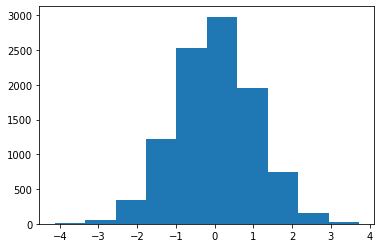

In [3]:
plt.hist(x)

In [4]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
import tensorflow as tf

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachma

In [5]:
model = Sequential()
#model.add(Lambda(redacted_set,input_shape =(1,)))
model.add(Dense(50, input_shape=(1,)))
model.add(Dense(128, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))
#model.compile(loss=lambda y_true, y_pred: DisCo(y_true, y_pred, model_DisCo.input, alpha = 1000), optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_model_DisCo = model.fit(np.concatenate([x,-x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=5, batch_size=int(0.01*len(x)))

preds = model.predict(np.concatenate([x,-x]))
print(roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]), preds))

Epoch 1/5
20000/20000 [==============================] - 2s 120us/step - loss: 0.6947 - acc: 0.4970
Epoch 2/5
20000/20000 [==============================] - 1s 47us/step - loss: 0.6938 - acc: 0.5012
Epoch 3/5
20000/20000 [==============================] - 1s 47us/step - loss: 0.6939 - acc: 0.4955
Epoch 4/5
20000/20000 [==============================] - 1s 46us/step - loss: 0.6936 - acc: 0.4996
Epoch 5/5
20000/20000 [==============================] - 1s 46us/step - loss: 0.6937 - acc: 0.4989
0.49518853


In [157]:
myinput = Input(shape=(1,))
encoded = Dense(128, activation='elu')(myinput)
encoded = Dense(64, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

decoded = Dense(128, activation='elu')(encoded)
decoded = Dense(164, activation='elu')(decoded)
decoded = Dense(1, activation='linear')(decoded)

autoencoder = Model(myinput, decoded)
encoder = Model(myinput, encoded)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, decoded]))

In [158]:
combinedModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 128)          256         input_12[0][0]                   
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 64)           8256        dense_68[0][0]                   
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 1)            65          dense_69[0][0]                   
__________________________________________________________________________________________________
dense_71 (

In [326]:
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    #return mse(y_true[:,0],y_true[:,1])
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                + 100*K.exp(-(y_true[:,0]-y_pred[:,0])**2) \
                + 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                + 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [327]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

Epoch 1/5
10000/10000 [==============================] - 4s 447us/step - loss: 0.0345
Epoch 2/5
10000/10000 [==============================] - 1s 61us/step - loss: 0.0029
Epoch 3/5
10000/10000 [==============================] - 1s 60us/step - loss: 0.0023
Epoch 4/5
10000/10000 [==============================] - 1s 59us/step - loss: 0.0017
Epoch 5/5
10000/10000 [==============================] - 1s 58us/step - loss: 0.0013


In [328]:
combinedModel.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
#combinedModel.compile(optimizer='adam', loss="mse")
combinedModel.fit(x,np.stack((x, x), axis=-1), epochs=20, batch_size=int(0.01*len(x)))

ValueError: slice index 2 of dimension 1 out of bounds. for 'loss_56/concatenate_28_loss/strided_slice_4' (op: 'StridedSlice') with input shapes: [?,2], [2], [2], [2] and with computed input tensors: input[1] = <0 2>, input[2] = <0 3>, input[3] = <1 1>.

In [162]:
mypreds = combinedModel.predict(x)
#mypreds = autoencoder.predict(x)

In [163]:
mypreds

array([[  9.749565  ,  -0.19684747],
       [ 58.66332   ,  -1.1270177 ],
       [ 82.589066  ,  -1.6887114 ],
       ...,
       [  7.236262  ,  -0.1544587 ],
       [-68.08147   ,   1.9448228 ],
       [-32.98022   ,   0.67787504]], dtype=float32)

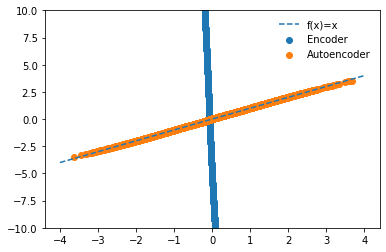

In [166]:
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label="Autoencoder")
plt.plot([-4,4],[-4,4],label="f(x)=x",ls="--")
plt.ylim([-10,10])
plt.legend(frameon=False)

In [365]:
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    #return mse(y_true[:,0],y_true[:,1])
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                + 1*K.exp(-(y_true[:,0]-y_pred[:,0])**2) \
                - 1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - 1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [376]:
myinput = Input(shape=(1,))
encoded = Dense(128, activation='elu')(myinput)
encoded = Dense(64, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)

encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

In [380]:
for layer in myclassifier_model.layers[:]:
    layer.trainable = False

In [381]:
combinedModel_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_219 (Dense)               (None, 128)          256         input_75[0][0]                   
__________________________________________________________________________________________________
dense_220 (Dense)               (None, 64)           8256        dense_219[0][0]                  
__________________________________________________________________________________________________
dense_221 (Dense)               (None, 1)            65          dense_220[0][0]                  
__________________________________________________________________________________________________
model_131 

In [368]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

Epoch 1/5
10000/10000 [==============================] - 6s 563us/step - loss: 0.0572
Epoch 2/5
10000/10000 [==============================] - 1s 60us/step - loss: 0.0077
Epoch 3/5
10000/10000 [==============================] - 1s 59us/step - loss: 0.0058
Epoch 4/5
10000/10000 [==============================] - 1s 58us/step - loss: 0.0038
Epoch 5/5
10000/10000 [==============================] - 1s 57us/step - loss: 0.0019


In [369]:
mypreds = autoencoder.predict(x)

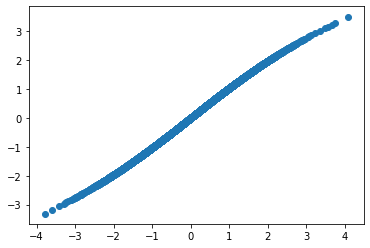

In [370]:
plt.scatter(x,mypreds)

In [371]:
#combinedModel.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
#combinedModel.fit(x,np.stack((x, x), axis=-1), epochs=20, batch_size=int(0.01*len(x)))

combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=10, batch_size=int(0.01*len(x)))

Epoch 1/10
10000/10000 [==============================] - 6s 649us/step - loss: -26.2501
Epoch 2/10
10000/10000 [==============================] - 1s 111us/step - loss: -31.9605
Epoch 3/10
10000/10000 [==============================] - 1s 110us/step - loss: -32.0330
Epoch 4/10
10000/10000 [==============================] - 1s 112us/step - loss: -32.0460
Epoch 5/10
10000/10000 [==============================] - 1s 110us/step - loss: -32.0500
Epoch 6/10
10000/10000 [==============================] - 1s 103us/step - loss: -32.0510
Epoch 7/10
10000/10000 [==============================] - 1s 104us/step - loss: -32.0553
Epoch 8/10
10000/10000 [==============================] - 1s 102us/step - loss: -32.0533
Epoch 9/10
10000/10000 [==============================] - 1s 105us/step - loss: -32.0565
Epoch 10/10
10000/10000 [==============================] - 1s 102us/step - loss: -32.0575


In [372]:
mypreds = combinedModel_classifier.predict(x)

In [373]:
mypreds

array([[ 1.04494276e+01, -9.13807571e-01,  5.16148134e-07,
         1.00000000e+00],
       [ 1.02351999e+01, -6.85038090e-01,  6.99424675e-07,
         1.00000000e+00],
       [ 8.15913486e+00,  1.46344686e+00,  3.93765149e-05,
         9.99991059e-01],
       ...,
       [ 1.15797825e+01, -2.14608669e+00,  1.22823124e-07,
         1.00000000e+00],
       [ 8.35955334e+00,  1.26035070e+00,  2.40509489e-05,
         9.99995232e-01],
       [ 8.68532562e+00,  9.28632975e-01,  1.13288743e-05,
         9.99998212e-01]], dtype=float32)

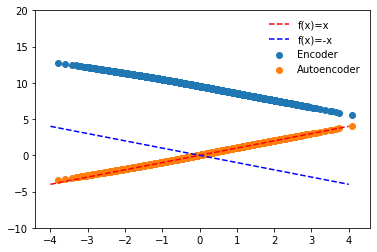

In [374]:
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label="Autoencoder")
plt.plot([-4,4],[-4,4],label="f(x)=x",ls="--",color="red")
plt.plot([-4,4],[4,-4],label="f(x)=-x",ls="--",color="blue")
plt.ylim([-10,20])
plt.legend(frameon=False)

In [251]:
vals = combinedModel.predict(np.linspace(-10,10,20))

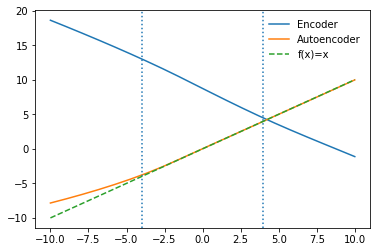

In [257]:
plt.plot(np.linspace(-10,10,20),vals[:,0],label="Encoder")
plt.plot(np.linspace(-10,10,20),vals[:,1],label="Autoencoder")
plt.axvline(-4,ls=":")
plt.axvline(4,ls=":")
plt.plot([-10,10],[-10,10],label="f(x)=x",ls="--")
plt.legend(frameon=False)

In [10]:
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    #return mse(y_true[:,0],y_true[:,1])
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                + 10*K.exp(-(y_true[:,0]-y_pred[:,0])**2) \
                - 1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - 1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [15]:
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(128, activation='elu')(myinput)
encoded = Dense(64, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=5, batch_size=int(0.01*len(x)))

    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=10, batch_size=int(0.01*len(x)))
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True

Epoch 1/5
10000/10000 [==============================] - 1s 149us/step - loss: 0.0817
Epoch 2/5
10000/10000 [==============================] - 0s 49us/step - loss: 0.0083
Epoch 3/5
10000/10000 [==============================] - 0s 49us/step - loss: 0.0063
Epoch 4/5
10000/10000 [==============================] - 0s 49us/step - loss: 0.0039
Epoch 5/5
10000/10000 [==============================] - 0s 49us/step - loss: 0.0022
on i= 0
Epoch 1/5
20000/20000 [==============================] - 2s 104us/step - loss: 0.6915
Epoch 2/5
20000/20000 [==============================] - 1s 51us/step - loss: 0.6911
Epoch 3/5
20000/20000 [==============================] - 1s 50us/step - loss: 0.6910
Epoch 4/5
20000/20000 [==============================] - 1s 51us/step - loss: 0.6911
Epoch 5/5
20000/20000 [==============================] - 1s 46us/step - loss: 0.6905
Epoch 1/10
10000/10000 [==============================] - 2s 206us/step - loss: -18.1183
Epoch 2/10
10000/10000 [===========================

10000/10000 [==============================] - 1s 83us/step - loss: 3.3716e-04
Epoch 9/10
10000/10000 [==============================] - 1s 80us/step - loss: 3.1777e-04
Epoch 10/10
10000/10000 [==============================] - 1s 82us/step - loss: 3.2938e-04
on i= 6
Epoch 1/5
20000/20000 [==============================] - 3s 155us/step - loss: 1.0977e-07
Epoch 2/5
20000/20000 [==============================] - 1s 53us/step - loss: 1.0966e-07
Epoch 3/5
20000/20000 [==============================] - 1s 53us/step - loss: 1.0965e-07
Epoch 4/5
20000/20000 [==============================] - 1s 52us/step - loss: 1.0964e-07
Epoch 5/5
20000/20000 [==============================] - 1s 54us/step - loss: 1.0963e-07
Epoch 1/10
10000/10000 [==============================] - 3s 315us/step - loss: 0.0849
Epoch 2/10
10000/10000 [==============================] - 1s 82us/step - loss: 3.7337e-04
Epoch 3/10
10000/10000 [==============================] - 1s 80us/step - loss: 3.3339e-04
Epoch 4/10
10000/10

In [16]:
mypreds = combinedModel_classifier.predict(x)

In [17]:
mypreds

array([[ 3.1662600e+01, -1.9336277e+00,  1.0000000e+00,  1.1096169e-16],
       [ 2.4443439e+01,  1.2742668e-01,  1.0000000e+00,  6.3700380e-13],
       [ 2.4448221e+01,  1.2607086e-01,  1.0000000e+00,  6.3323636e-13],
       ...,
       [ 2.5994818e+01, -3.1265935e-01,  1.0000000e+00,  9.4628908e-14],
       [ 2.8675831e+01, -1.0763761e+00,  1.0000000e+00,  3.7529857e-15],
       [ 2.7465315e+01, -7.3093677e-01,  1.0000000e+00,  1.5967562e-14]],
      dtype=float32)

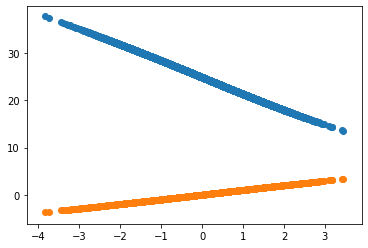

In [18]:
plt.scatter(x,mypreds[:,0])
plt.scatter(x,mypreds[:,1])

In [35]:
#K.clear_session()

In [8]:
xx = []
yy = []
for c in np.linspace(-5,5,10):
    encoded_x = c - x
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myloss = myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=5, batch_size=int(0.01*len(x)))
    print(myloss.history['loss'][-1])
    xx+=[c]
    yy+=[myloss.history['loss'][-1]]

Epoch 1/5
20000/20000 [==============================] - 1s 54us/step - loss: 0.1079
Epoch 2/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0209
Epoch 3/5
20000/20000 [==============================] - 1s 44us/step - loss: 0.0199
Epoch 4/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0195
Epoch 5/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0198
0.019753671530343127
Epoch 1/5
20000/20000 [==============================] - 1s 55us/step - loss: 0.0768
Epoch 2/5
20000/20000 [==============================] - 1s 44us/step - loss: 0.0745
Epoch 3/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0739
Epoch 4/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.0741
Epoch 5/5
20000/20000 [==============================] - 1s 44us/step - loss: 0.0738
0.07377640344202518
Epoch 1/5
20000/20000 [==============================] - 1s 58us/step - loss: 0.2138
Epoch 2/5
20000/20000 [=

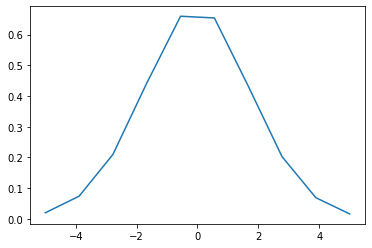

In [9]:
plt.plot(xx,yy)

In [19]:
#Try doing this fit automatically?  Just need 

In [104]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._c = self.add_weight(name='x', 
                                    shape=(1,),
                                    initializer=initializer, #'uniform',
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return self._c - x

In [105]:
mymodel_inputtest = Input(shape=(1,))
mymodel_test = MyLayer()(mymodel_inputtest)
myclassifier_model_test = Model(mymodel_inputtest, mymodel_test)

In [106]:
myclassifier_model_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
my_layer_13 (MyLayer)        (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [107]:
x_transform = myclassifier_model_test.predict(x)

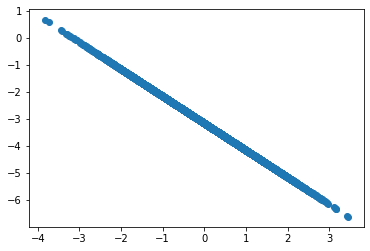

In [108]:
plt.scatter(x,x_transform)

In [109]:
def myloss(y_true, y_pred, alpha = 0.):
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - 1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [118]:
myinput = Input(shape=(1,))
encoded = MyLayer()(myinput)

encoder = Model(myinput, encoded)

encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=5, batch_size=int(0.01*len(x)))

    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=10, batch_size=int(0.01*len(x)))
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True

on i= 0
Epoch 1/5
20000/20000 [==============================] - 7s 328us/step - loss: 0.3079
Epoch 2/5
20000/20000 [==============================] - 1s 59us/step - loss: 0.2810
Epoch 3/5
20000/20000 [==============================] - 1s 57us/step - loss: 0.2829
Epoch 4/5
20000/20000 [==============================] - 1s 54us/step - loss: 0.2812
Epoch 5/5
20000/20000 [==============================] - 1s 53us/step - loss: 0.2805
Epoch 1/10
10000/10000 [==============================] - 6s 611us/step - loss: -5.5978
Epoch 2/10
10000/10000 [==============================] - 1s 56us/step - loss: -5.9489
Epoch 3/10
10000/10000 [==============================] - 1s 53us/step - loss: -6.3399
Epoch 4/10
10000/10000 [==============================] - 1s 56us/step - loss: -6.7719
Epoch 5/10
10000/10000 [==============================] - 1s 54us/step - loss: -7.2438
Epoch 6/10
10000/10000 [==============================] - 1s 60us/step - loss: -7.7526
Epoch 7/10
10000/10000 [===================

20000/20000 [==============================] - 1s 55us/step - loss: 0.6853
Epoch 5/5
20000/20000 [==============================] - 1s 53us/step - loss: 0.6855
Epoch 1/10
10000/10000 [==============================] - 7s 721us/step - loss: -15.8238
Epoch 2/10
10000/10000 [==============================] - 1s 59us/step - loss: -15.9240
Epoch 3/10
10000/10000 [==============================] - 1s 53us/step - loss: -16.0236
Epoch 4/10
10000/10000 [==============================] - 1s 54us/step - loss: -16.1227
Epoch 5/10
10000/10000 [==============================] - 1s 59us/step - loss: -16.2211
Epoch 6/10
10000/10000 [==============================] - 1s 52us/step - loss: -16.3187
Epoch 7/10
10000/10000 [==============================] - 1s 50us/step - loss: -16.4154
Epoch 8/10
10000/10000 [==============================] - 1s 50us/step - loss: -16.5111
Epoch 9/10
10000/10000 [==============================] - 0s 50us/step - loss: -16.6055
Epoch 10/10
10000/10000 [======================

In [119]:
mypreds = combinedModel_classifier.predict(x)

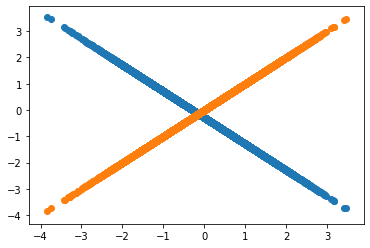

In [120]:
plt.scatter(x,mypreds[:,0])
plt.scatter(x,mypreds[:,1])

In [125]:
myvals = []
for i in range(10):
    print(i)
    myinput = Input(shape=(1,))
    encoded = Dense(1, activation='relu')(myinput)
    #encoded = Dense(64, activation='elu')(encoded)
    #encoded = Dense(1, activation='linear')(encoded)

    encoder = Model(myinput, encoded)
    myvals += [encoder.predict(np.linspace(-4,4,10))]

0
1
2
3
4
5
6
7
8
9


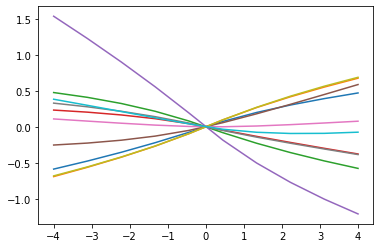

In [124]:
for i in range(10):
    plt.plot(np.linspace(-4,4,10),myvals[i])

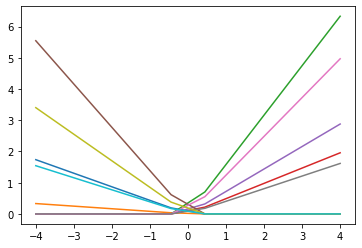

In [126]:
for i in range(10):
    plt.plot(np.linspace(-4,4,10),myvals[i])

In [5]:
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - 1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput

In [132]:
myinput = Input(shape=(1,))
encoded = Dense(128, activation='elu')(myinput)
encoded = Dense(64, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

Epoch 1/5
10000/10000 [==============================] - 10s 1ms/step - loss: 0.0495
Epoch 2/5
10000/10000 [==============================] - 1s 61us/step - loss: 0.0083
Epoch 3/5
10000/10000 [==============================] - 1s 62us/step - loss: 0.0067
Epoch 4/5
10000/10000 [==============================] - 1s 61us/step - loss: 0.0051
Epoch 5/5
10000/10000 [==============================] - 1s 61us/step - loss: 0.0039


In [135]:
mypreds = autoencoder.predict(x)
mypreds_e = encoder.predict(x)

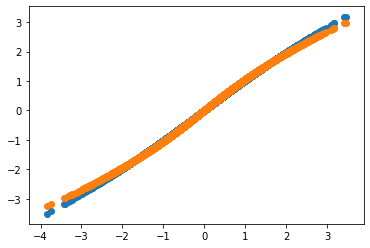

In [136]:
plt.scatter(x,mypreds_e[:,0])
plt.scatter(x,mypreds[:,0])

In [6]:
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(5, activation='elu')(myinput)
encoded = Dense(5, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

preds = []

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=5, batch_size=int(0.01*len(x)))

    y_scores = encoder.predict(np.concatenate([x,encoded_x]))
    print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))
    
    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=10, batch_size=int(0.01*len(x)))
    
    preds += [encoder.predict(np.linspace(-4,4,10))]
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True

Epoch 1/5
10000/10000 [==============================] - 2s 197us/step - loss: 0.0796
Epoch 2/5
10000/10000 [==============================] - 0s 42us/step - loss: 0.0512
Epoch 3/5
10000/10000 [==============================] - 0s 42us/step - loss: 0.0293
Epoch 4/5
10000/10000 [==============================] - 0s 43us/step - loss: 0.0129
Epoch 5/5
10000/10000 [==============================] - 0s 42us/step - loss: 0.0051
on i= 0
Epoch 1/5
20000/20000 [==============================] - 1s 58us/step - loss: 0.6687
Epoch 2/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.6681
Epoch 3/5
20000/20000 [==============================] - 1s 44us/step - loss: 0.6685
Epoch 4/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.6678
Epoch 5/5
20000/20000 [==============================] - 1s 45us/step - loss: 0.6678
0 0.37420580000000003
Epoch 1/10
10000/10000 [==============================] - 1s 101us/step - loss: -15.9694
Epoch 2/10
10000/10000 [======

10000/10000 [==============================] - 1s 70us/step - loss: -16.1034
Epoch 9/10
10000/10000 [==============================] - 1s 70us/step - loss: -16.1063
Epoch 10/10
10000/10000 [==============================] - 1s 70us/step - loss: -16.1086
on i= 6
Epoch 1/5
20000/20000 [==============================] - 2s 82us/step - loss: 1.0586
Epoch 2/5
20000/20000 [==============================] - 1s 49us/step - loss: 0.6837
Epoch 3/5
20000/20000 [==============================] - 1s 47us/step - loss: 0.6826
Epoch 4/5
20000/20000 [==============================] - 1s 46us/step - loss: 0.6830
Epoch 5/5
20000/20000 [==============================] - 1s 48us/step - loss: 0.6828
6 0.412785885
Epoch 1/10
10000/10000 [==============================] - 2s 152us/step - loss: -17.6883
Epoch 2/10
10000/10000 [==============================] - 1s 72us/step - loss: -20.1854
Epoch 3/10
10000/10000 [==============================] - 1s 69us/step - loss: -20.6117
Epoch 4/10
10000/10000 [==========

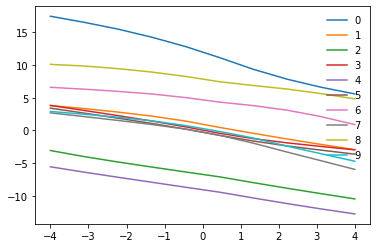

In [7]:
for i in range(len(preds)):
    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
    pass
plt.legend(frameon=False)

In [8]:
mypreds = combinedModel_classifier.predict(x)

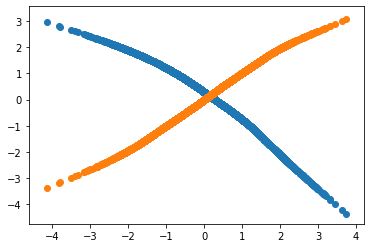

In [9]:
plt.scatter(x,mypreds[:,0])
plt.scatter(x,mypreds[:,1])